In [38]:
# read CT imaging
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
from pydicom.data import get_testdata_files
#plt.rcParams['figure.figsize'] = [32, 20]
print(__doc__)

Automatically created module for IPython interactive environment


In [39]:
def plot_ct(dataset):
    # Normal mode:
    print()
    #print("Filename.........:", filename)
    print("Storage type.....:", dataset.SOPClassUID)
    print()
    
    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name...:", display_name)
    print("Patient id.......:", dataset.PatientID)
    print("Modality.........:", dataset.Modality)
    print("Study Date.......:", dataset.StudyDate)

    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

    # use .get() if not sure the item exists, and want a default value if missing
    print("Slice location...:", dataset.get('SliceLocation', "(missing)"))
    fig = plt.figure(figsize=(16,10))
    # plot the image using matplotlib
    ax = fig.add_subplot(211)
    ax.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    ax = fig.add_subplot(212)
    ax.hist(dataset.pixel_array[::])

In [40]:
def find_by_location(data_all, slide_location, index, margin = 2.0):
    if index < 4:
        data_all, path_all, _, _ = data_all
    else:
        _, _, data_all, path_all = data_all
        index = index % 4
    location = []
    i = 0
    while not location or location == 'missing' or abs(float(location)-slide_location) > margin:
        if i >= len(data_all[index]):
            i = 0
            margin += 1
        dataset = pydicom.dcmread(join(path_all[index], data_all[index][i]))
        # get the slide location of the all patients and get others with similar slide location
        location = dataset.get('SliceLocation', "(missing)")
        i += 1
    return dataset, location

In [41]:
def pairwise_plot_ct_with_path(data_all, slide_location = [], random = True):
    '''
    subplot 8x2 => 4 normal dose/ 4 low dose with hist as well
    same slice location(diff in loc < 2)
    params:
    data_all: std_data_all, std_path_all, low_data_all, low_path_all
    random: True/False for random sampling
    '''
    # unpack data
    std_data_all, std_path_all, low_data_all, low_path_all = data_all
    # random pick on index from firs patient
    index = np.random.randint(low=0, high=len(std_data_all[0]))
    while not slide_location or slide_location == 'missing':
        dataset = pydicom.dcmread(join(low_path_all[2], low_data_all[2][index]))
        # get the slide location of the first patient and get others with similar slide location
        slide_location = dataset.get('SliceLocation', "(missing)")
    fig = plt.figure(figsize=(20,40))
    print('ref location', slide_location)
    for i in range(1, 9):
        # get the data by given slide location
        if i < 7:
            dataset, location = find_by_location(data_all, float(slide_location), i-1)
        else:
            dataset, location = find_by_location(data_all, float(slide_location)-180, i-1)
        print('slide location', location)
        ax = fig.add_subplot(8, 2, 2*i-1)
        #ax.text(0.5, 0.5, str((8, 2, i)),fontsize=18, ha='center')
            # plot the image using matplotlib
        ax.imshow(dataset.pixel_array, cmap=plt.cm.bone)
        # histn plot of each pixel
        ax = fig.add_subplot(8,2,2*i)
        ax.hist(dataset.pixel_array[::], bins = 200)

In [42]:
def find_by_loc_with_path(datas, slide_location, index, margin = 2.0):
    if index < 4:
        data_all, path_all, _, _ = datas
    else:
        _, _, data_all, path_all = datas
        index = index % 4
    location = []
    i = 0
    while not location or location == 'missing' or abs(float(location)-slide_location) > margin:
        if i >= len(data_all[index]):
            i = 0
            margin += 1
        dataset = pydicom.dcmread(join(path_all[index], data_all[index][i]))
        # get the slide location of the all patients and get others with similar slide location
        location = dataset.get('SliceLocation', "(missing)")
        i += 1
    return dataset, location

In [43]:
def pairwise_plot_ct_with_path(datas, slide_location = [], random = True):
    '''
    subplot 8x2 => 4 normal dose/ 4 low dose with hist as well
    same slice location(diff in loc < 2)
    params:
    data_all: std_data_all, std_path_all, low_data_all, low_path_all
    random: True/False for random sampling
    '''
    # unpack data
    std_data_all, std_path_all, low_data_all, low_path_all = datas
    # random pick on index from firs patient
    index = np.random.randint(low=0, high=len(std_data_all[0]))
    while not slide_location or slide_location == 'missing':
        dataset = pydicom.dcmread(join(low_path_all[2], low_data_all[2][index]))
        # get the slide location of the first patient and get others with similar slide location
        slide_location = dataset.get('SliceLocation', "(missing)")
    fig = plt.figure(figsize=(20,40))
    print('ref location', slide_location)
    for i in range(1, 9):
        # get the data by given slide location
        if i < 7:
            dataset, location = find_by_location(datas, float(slide_location), i-1)
        else:
            dataset, location = find_by_location(datas, float(slide_location)-180, i-1)
        print('slide location', location)
        ax = fig.add_subplot(8, 2, 2*i-1)
        #ax.text(0.5, 0.5, str((8, 2, i)),fontsize=18, ha='center')
            # plot the image using matplotlib
        ax.imshow(dataset.pixel_array, cmap=plt.cm.bone)
        # histn plot of each pixel
        ax = fig.add_subplot(8,2,2*i)
        ax.hist(dataset.pixel_array[::], bins = 200)

In [44]:
#%%javascript
#IPython.OutputArea.prototype._should_scroll = function(lines) {
#    return false;
#}

In [45]:
from os import listdir
from os.path import isfile, join
def load_data(path = ''):

        # reading files from folders
        filenames = [f for f in listdir(path) if isfile(join(path, f))]
        return filenames
def load_filepath_dfs(path = '', depth = 0, data_all = [], path_all= []):
        #get all paths for depth
        if depth == 0:
            filenames = [f for f in listdir(path) if isfile(join(path, f))]
            data_all.append(filenames)
            path_all.append(path)
            return
        for f in listdir(path):
            load_data_dfs(join(path, f), depth - 1, data_all, path_all)
        return
def load_data_dfs(path = '', depth = 0, data_all = []):
        # reading files from folders
        if depth == 0:
            files = []
            for f in listdir(path):
                if isfile(join(path, f)):
                    files.append(pydicom.dcmread(join(path,f)))
            data_all.append(files)
            return
        for f in listdir(path):
            load_data_dfs(join(path, f), depth - 1, data_all)
        return

In [46]:
def find_by_location(data_all, slide_location, index, margin = 2.0):
    if index < 4:
        datas, _ = data_all
    else:
        _, datas = data_all
        index = index % 4
    location = []
    i = 0
    while not location or location == 'missing' or abs(float(location)-slide_location) > margin:
        if i >= len(datas[index]):
            i = 0
            margin += 1
        dataset = datas[index][i]
        # get the slide location of the all patients and get others with similar slide location
        location = dataset.get('SliceLocation', "(missing)")
        i += 1
    return dataset, location

In [61]:
def pairwise_plot_ct(data_all, slide_location = [], random = True):
    '''
    subplot 8x2 => 4 normal dose/ 4 low dose with hist as well
    same slice location(diff in loc < 2)
    params:
    data_all: std_data_all, std_path_all, low_data_all, low_path_all
    random: True/False for random sampling
    '''
    # unpack data
    std_data_all, low_data_all = data_all
    # random pick on index from firs patient
    index = np.random.randint(low=0, high=len(std_data_all[0]))
    while not slide_location or slide_location == 'missing':
        dataset = std_data_all[0][index]
        # get the slide location of the first patient and get others with similar slide location
        slide_location = dataset.get('SliceLocation', "(missing)")
    fig = plt.figure(figsize=(20,40))
    print('ref location', slide_location)
    for i in range(1, 9):
        # get the data by given slide location
        if i == 6 or i ==7:
            dataset, location = find_by_location(data_all, float(slide_location) - 180, i-1)
        else:
            dataset, location = find_by_location(data_all, float(slide_location), i-1)
        print('slide location', location)
        ax = fig.add_subplot(8, 2, 2*i-1)
        #ax.text(0.5, 0.5, str((8, 2, i)),fontsize=18, ha='center')
            # plot the image using matplotlib
        ax.imshow(dataset.pixel_array, cmap=plt.cm.bone)
        # histn plot of each pixel
        ax = fig.add_subplot(8,2,2*i)
        ax.hist(np.array(dataset.pixel_array).flatten(),bins=100)# hist is much faster with numpyarray

In [48]:
low_data_all = []
#low_path_all = []
#low_path = '/Users/ningxin/Dropbox/Research/FHE_Meeting5th/CT/Low/'
low_path = '../CT/Low/'
load_data_dfs(low_path, 2, low_data_all)

In [49]:
std_data_all = []
#std_path_all = []
#std_path = '/Users/ningxin/Dropbox/Research/FHE_Meeting5th/CT/High/'
std_path = '../CT/High/'
load_data_dfs(std_path, 2, std_data_all)

In [50]:
len(std_data_all[1])

345

In [51]:
data_all = std_data_all, low_data_all

ref location 86.57
slide location 85.57
slide location 84.71
slide location 88.5
slide location 86.63
slide location 88.09
slide location -95.105
slide location -93.000
slide location 85.5


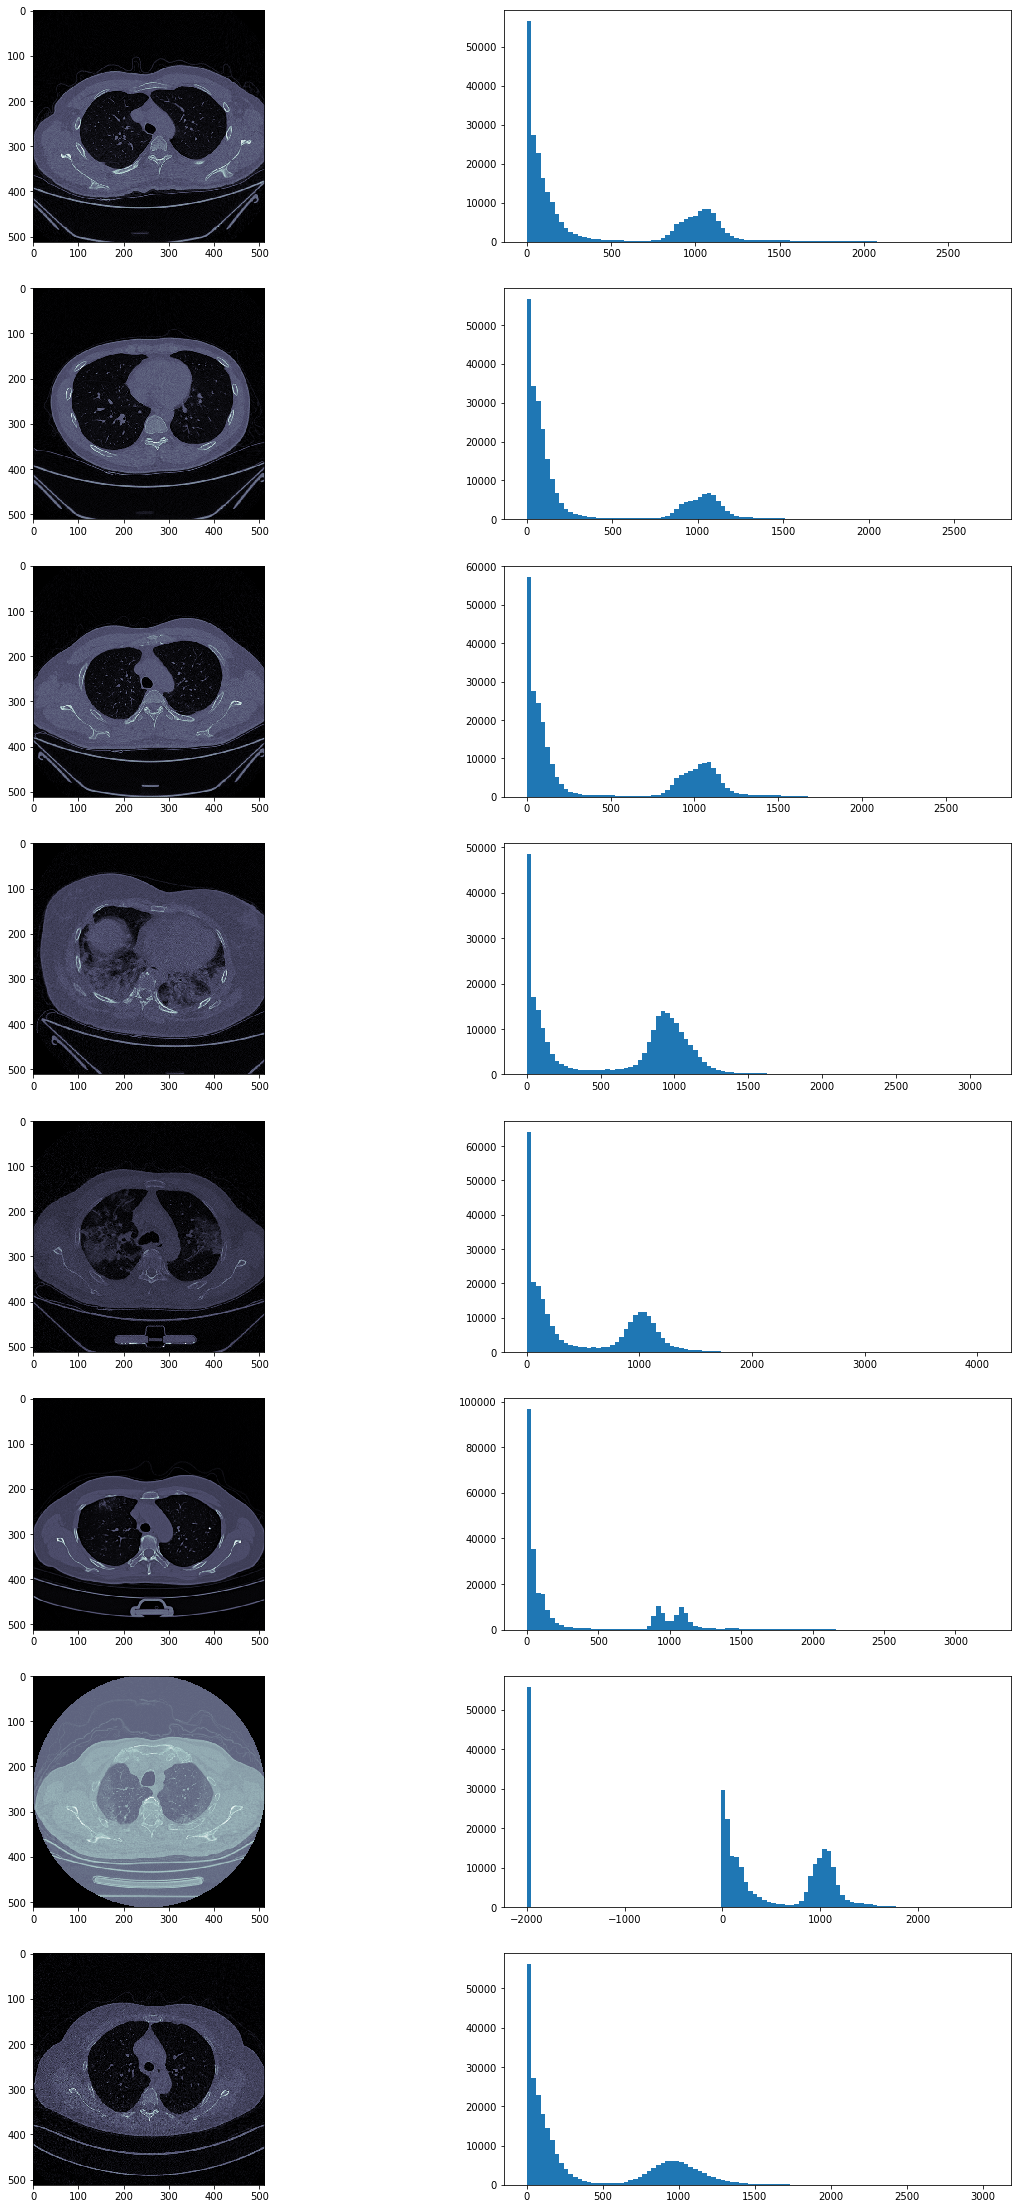

In [62]:
pairwise_plot_ct(data_all, random = True)